Taller 1.

Herraminetas Computacionales

Camilo Santiago Castillo Lasso

201412050

In [1]:
import os
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Funcion que retorna la serie IDEAM 

Parametros: nombre de la ciudad

retorno: serie_IDEAM

In [14]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
def serie_IDEAM(ciudad):
    serie_csvIDEAM=os.path.join(base_dir,ciudad,'IDEAM'+'.csv')
    serie_IDEAM=pd.read_csv(serie_csvIDEAM, sep=';',encoding='latin-1')
    return serie_IDEAM

Funcion que retorna la serie NREL 

Parametros: nombre de la ciudad

retorno: serie_NREL

In [15]:
def serie_NREL(ciudad):
    serie_csvNREL=os.path.join(base_dir,ciudad,'NREL'+'.csv')
    serie_NREL=pd.read_csv(serie_csvNREL, sep=';',encoding='latin-1')
    return serie_NREL

Funcion que retorna las series IDEAM y NREL.

Parametros: nombre ciudad.

retorna: serie_IDEAM, serie_NREL

In [16]:
def darSeries(ciudad):
    return serie_IDEAM(ciudad), serie_NREL(ciudad)

Funcion que retorna la energia total en $kWh/m^2$ para cada mes de la serie horaria.

Parametros: serie horaria.

Retorna: serie con el total de energia y dias por mes

In [26]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            
    return ghi_df

Funcion que calcula el promedio de energia diario mensual para la serie.

Parametros: Serie mensual.

Retorna: Serie con el promedio diaria mensual de energia en $kWh/m^2$.

In [27]:
def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            
    return ghi_df

Funcion que realiza una grafica de la distribucion de la energia mensula promedio a partir de una serie horaria.

Parametros: serie horaria, nombre de la serie, color de la serie

In [35]:
def graficarDistribucionDeEnergia(serieHoraria, nombre, color):
    
    ghiMensual=ghi_mensual(serieHoraria)
    ghiDiario=ghi_dia(ghiMensual)
    datos=sorted(ghiDiario['GHIdiario'])
    
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    numdatos = range(len(datos))
    pylab.plot(numdatos,datos/datos[0],color, label=nombre)
    pylab.legend(loc='upper left')

Prueba de el funcionamineto de las funciones planteadas.

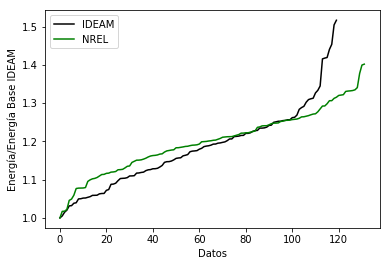

In [37]:
ideam, nrel=darSeries('Valledupar')
graficarDistribucionDeEnergia(ideam, 'IDEAM','-k')
graficarDistribucionDeEnergia(nrel, 'NREL','-g')

Funcion que calcula la enerergia que se obtendra el 99% de las veces a partir de una serie horaria.

Parametros: serie horaria.

Retorna: valor de la ENFICC

In [40]:
def percentil1(serieHoraria):
    percentil=0.01
    
    ghiMensual=ghi_mensual(serieHoraria)
    ghiDiario=ghi_dia(ghiMensual)
    
    enficc=ghiDiario.quantile(q=percentil, numeric_only=True)['GHIdiario']
    return enficc

Funcion que calcula la media y la desviacion estandar poblacional a partir de una columna de datos.

Parametros: columna de la serie de datos.

Retorna: media y desviacion estandar poblacional.

In [43]:
def prom_desv(ColumnaSerie):
    return np.mean(ColumanSerie), np.std(ColumnaSerie)